## Supervised model for classifying segments.

Since Kmeans does an unsupervised classification, therefore sets labels to segments, It is not known which label corresponds to the steps, and the true steps were used to determine the highest score.
This time we will use a supervised model.

## Data preparation.

Since the data we have is mainly gait signals, we will construct a database of true segments, where a segment is described by 56 features which the result of describe method of the pandas library. All this data is stored in a file name data_label.csv.

In [ ]:
from main import *
import csv

n_indiv=230
n_try=20
directory=r"C:\Users\Yassine\Desktop\GaitData"
data_steps=[]
label=[]

  
for k in range(1,n_indiv+1):
        #print(i)
    for j in range(1,n_try+1):
        
        file=directory+"\\"+str(k)+"-"+str(j)+".csv"
        if (str(k)+"-"+str(j)+".csv" in listdir(directory)):
            print(k,"--",j)
            data=data_acquisition(file)
            meta_data=data[1]
            right=meta_data['RightFootActivity']
            left=meta_data['LeftFootActivity']
            signal=data[0]
            left_signal=signal.iloc[:,0:8]
            right_signal=signal.iloc[:,8:16]
            right_cp=np.asarray(right).reshape(len(right)*2)
            left_cp=np.asarray(left).reshape(len(left)*2)
            right_segments=[]
            left_segments=[]
            e=signal.shape[0]
            right_segments.append([0,right_cp[0]])
            left_segments.append([0,left_cp[0]])
            for i in range(len(right_cp)-1):
                right_segments.append([right_cp[i],right_cp[i+1]])
            right_segments.append([right_cp[len(right_cp)-1],e])
            for i in range(len(left_cp)-1):
                left_segments.append([left_cp[i],left_cp[i+1]])
            left_segments.append([left_cp[len(left_cp)-1],e])
            for s in right_segments:
                chunk=right_signal.iloc[s[0]:s[1],:]
                vector=np.asarray(chunk.describe().iloc[1:8,]).flatten().tolist()
                if s in right:
                    vector.append(1)
                else:
                    vector.append(0)
                data_steps.append(vector)
                
            for s in left_segments:
                chunk=left_signal.iloc[s[0]:s[1],:]
                vector=np.asarray(chunk.describe().iloc[1:8,]).flatten().tolist()
                if s in left:
                    vector.append(1)
                else:
                    vector.append(0)
                data_steps.append(vector)
        
df=pd.DataFrame(data_steps)
df.to_csv('data_label.csv', index=False)

## Preprocessing

Naturally, we delete data with anomaly (NaN values) and divide our dataset into a training and testing data, the proportion of training data is 15% of the considered data (12000 sample).
For the model, we use a Random forest model.

In [2]:
from main import *
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

# =============================================================================
# 
df=pd.read_csv("data_label.csv").iloc[:,:]
to_del=[i for i in set(np.where(np.isnan(df))[0])]
df=df.drop(to_del)
X=df.iloc[:,0:df.shape[1]-1]
Y=df.iloc[:,df.shape[1]-1]
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.85)
print("X_train shape ",X_train.shape)
print("X_test shape ",X_test.shape)
print("fitting model ...")
clf=RandomForestClassifier(n_estimators=100)
clf.fit(X_train,Y_train)
Y_pred = clf.predict(X_test)
error=sum(abs(Y_pred-Y_test))
print("precision = ", 1-(error/len(Y_test)))

X_train shape  (12371, 56)
X_test shape  (70108, 56)
fitting model ...
precision =  0.9947652193758202


## Running with all the segments.

Without scaling

note: better than doing every files separately (0.948 f_score)

In [2]:
from main import *
def process(link,method,cost,side):
    print("initiating process for: ",link)
    data=data_acquisition(link)
    meta_data=data[1]
    subject=int(meta_data['Subject'])
    trial=int(meta_data['Trial'])
    data=get_side_data(data,side)
    df=data[0]
    #df=pd.DataFrame(preprocessing.scale(df))
    steps=data[1]
    data=df
    signals=np.asarray(data)
    bkps=np.asarray(steps)
    bkps=bkps.reshape(bkps.shape[1]*bkps.shape[0])
    algo = method(custom_cost=cost).fit(signals)
    my_bkps = np.asarray(algo.predict(n_bkps=len(bkps)+1))[0:]
    segs=[]
    detected_steps=[]
    L=[]
    for i in range(len(my_bkps)-1):
        segs.append((my_bkps[i],my_bkps[i+1]))
    for s in segs:
        chunk=data.iloc[s[0]:s[1],:]
        scaled=chunk
        summ=scaled.describe().iloc[1:8,]
        vector=np.asarray(summ).flatten()
        #vector=np.linalg.norm(summ,axis=1)
        vector=np.append(vector,[subject,trial])
        L.append(vector)
    L=np.asarray(L)
    return (L,segs)

def chain(directory,method,cost,side,n_indiv,n_try):
  ### Dict that associates each type of pathology to it's files   
# =============================================================================
    df=pd.read_csv("data_label.csv").iloc[:,:]
    to_del=[i for i in set(np.where(np.isnan(df))[0])]
    df=df.drop(to_del)
    X=df.iloc[:,0:df.shape[1]-1]
    Y=df.iloc[:,df.shape[1]-1]
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.85)
    print("fitting model ...")
    clf=RandomForestClassifier(n_estimators=100)
    clf.fit(X_train,Y_train)
    Y_test=clf.predict(X)
    print(sum(Y_test)/len(Y_test))

    pathology_group=dict()
   ### Dict that associates each file it's info     
    info=dict()
 
    L=[]
  ### List of each vector describing a segment + the file code ####  
    for i in range(1,n_indiv+1):
        for j in range(1,n_try+1):

        

            file=directory+"\\"+str(i)+"-"+str(j)+".csv"
            if (str(i)+"-"+str(j)+".csv" in listdir(directory)):
                data=data_acquisition(file)
                meta_data=data[1]
                type_illness=meta_data["PathologyGroup"]
                print(type_illness)
   ##### Assign each file to illness type to keep count ######             
                if (not(type_illness in pathology_group)):
                    pathology_group[type_illness]=[]
                    pathology_group[type_illness].append((i,j))
                else:
                    pathology_group[type_illness].append((i,j))
                    
                
   ##### Construction of a dict to keep track of information in the file ######
                result=process(file,method,cost,side)
                steps=get_side_data(data,side)[1]
                res=result[0]
                segments=result[1]
                info[(i,j)]=(type_illness,segments,steps)
                for k in res:
                    L.append(k)
              
            
        
            else:
                break
    L=np.asarray(L)
    X=L[:,0:L.shape[1]-2]
    print(pd.DataFrame(L))
    print(X_test.shape)
    Y_pred =clf.predict(X)
    labels=Y_pred
    print(sum(labels)/len(labels))
    dict_labels=dict()
#### Storing segments labels for each file ########
    for i in range(len(labels)):
        code=(L[i,L.shape[1]-2],L[i,L.shape[1]-1])
        if (code not in dict_labels):
            dict_labels[code]=[]
            dict_labels[code].append(labels[i])
        else:
            dict_labels[code].append(labels[i])
##### Construction of a dict containing detected_steps + f_score for each file
    results=dict()
    score_pathology=dict()
    for i in dict_labels:
        seg=info[i][1]
        pathology=info[i][0]
        
        steps=info[i][2]
        
        labels=dict_labels[i]
        
        detected_steps=[]
        for j in range(len(labels)):
            if (labels[j]==1):
                detected_steps.append(seg[j])
        #print(detected_steps)
        results[i]=f_score(detected_steps,steps)
        #print(i,"     ",results[i])
        if (pathology in score_pathology):
            score_pathology[pathology]=score_pathology[pathology]+results[i]
        else:
            score_pathology[pathology]=results[i]
    for i in score_pathology:
        score_pathology[i]=score_pathology[i]/len(pathology_group[i])
    
    
    
        
    return(results,score_pathology,L)

link=r"C:\Users\Yassine\Desktop\GaitData\230-5.csv"
side="right"
res=chain(r"C:\Users\Yassine\Desktop\GaitData",rpt.BottomUp,MyCost(),side,230,20)

fitting model ...
0.4886698432328229
Neurological
initiating process for:  C:\Users\Yassine\Desktop\GaitData\1-1.csv
Neurological
initiating process for:  C:\Users\Yassine\Desktop\GaitData\1-2.csv
Neurological
initiating process for:  C:\Users\Yassine\Desktop\GaitData\1-3.csv
Neurological
initiating process for:  C:\Users\Yassine\Desktop\GaitData\1-4.csv
Neurological
initiating process for:  C:\Users\Yassine\Desktop\GaitData\1-5.csv
Neurological
initiating process for:  C:\Users\Yassine\Desktop\GaitData\2-1.csv
Neurological
initiating process for:  C:\Users\Yassine\Desktop\GaitData\2-2.csv
Neurological
initiating process for:  C:\Users\Yassine\Desktop\GaitData\2-3.csv
Healthy
initiating process for:  C:\Users\Yassine\Desktop\GaitData\3-1.csv
Healthy
initiating process for:  C:\Users\Yassine\Desktop\GaitData\3-2.csv
Healthy
initiating process for:  C:\Users\Yassine\Desktop\GaitData\3-3.csv
Healthy
initiating process for:  C:\Users\Yassine\Desktop\GaitData\3-4.csv
Healthy
initiating proc

Healthy
initiating process for:  C:\Users\Yassine\Desktop\GaitData\21-1.csv
Healthy
initiating process for:  C:\Users\Yassine\Desktop\GaitData\21-2.csv
Healthy
initiating process for:  C:\Users\Yassine\Desktop\GaitData\21-3.csv
Healthy
initiating process for:  C:\Users\Yassine\Desktop\GaitData\21-4.csv
Neurological
initiating process for:  C:\Users\Yassine\Desktop\GaitData\22-1.csv
Neurological
initiating process for:  C:\Users\Yassine\Desktop\GaitData\22-2.csv
Neurological
initiating process for:  C:\Users\Yassine\Desktop\GaitData\22-3.csv
Neurological
initiating process for:  C:\Users\Yassine\Desktop\GaitData\22-4.csv
Neurological
initiating process for:  C:\Users\Yassine\Desktop\GaitData\22-5.csv
Neurological
initiating process for:  C:\Users\Yassine\Desktop\GaitData\23-1.csv
Neurological
initiating process for:  C:\Users\Yassine\Desktop\GaitData\23-2.csv
Neurological
initiating process for:  C:\Users\Yassine\Desktop\GaitData\23-3.csv
Neurological
initiating process for:  C:\Users\Y

Healthy
initiating process for:  C:\Users\Yassine\Desktop\GaitData\43-5.csv
Neurological
initiating process for:  C:\Users\Yassine\Desktop\GaitData\44-1.csv
Neurological
initiating process for:  C:\Users\Yassine\Desktop\GaitData\44-2.csv
Neurological
initiating process for:  C:\Users\Yassine\Desktop\GaitData\44-3.csv
Neurological
initiating process for:  C:\Users\Yassine\Desktop\GaitData\44-4.csv
Neurological
initiating process for:  C:\Users\Yassine\Desktop\GaitData\45-1.csv
Neurological
initiating process for:  C:\Users\Yassine\Desktop\GaitData\45-2.csv
Neurological
initiating process for:  C:\Users\Yassine\Desktop\GaitData\45-3.csv
Neurological
initiating process for:  C:\Users\Yassine\Desktop\GaitData\45-4.csv
Neurological
initiating process for:  C:\Users\Yassine\Desktop\GaitData\45-5.csv
Neurological
initiating process for:  C:\Users\Yassine\Desktop\GaitData\46-1.csv
Neurological
initiating process for:  C:\Users\Yassine\Desktop\GaitData\46-2.csv
Orthopedic
initiating process for

Neurological
initiating process for:  C:\Users\Yassine\Desktop\GaitData\68-3.csv
Neurological
initiating process for:  C:\Users\Yassine\Desktop\GaitData\68-4.csv
Neurological
initiating process for:  C:\Users\Yassine\Desktop\GaitData\68-5.csv
Neurological
initiating process for:  C:\Users\Yassine\Desktop\GaitData\69-1.csv
Neurological
initiating process for:  C:\Users\Yassine\Desktop\GaitData\69-2.csv
Neurological
initiating process for:  C:\Users\Yassine\Desktop\GaitData\69-3.csv
Neurological
initiating process for:  C:\Users\Yassine\Desktop\GaitData\69-4.csv
Neurological
initiating process for:  C:\Users\Yassine\Desktop\GaitData\69-5.csv
Neurological
initiating process for:  C:\Users\Yassine\Desktop\GaitData\70-1.csv
Neurological
initiating process for:  C:\Users\Yassine\Desktop\GaitData\70-2.csv
Neurological
initiating process for:  C:\Users\Yassine\Desktop\GaitData\71-1.csv
Neurological
initiating process for:  C:\Users\Yassine\Desktop\GaitData\71-2.csv
Neurological
initiating proc

Orthopedic
initiating process for:  C:\Users\Yassine\Desktop\GaitData\93-1.csv
Orthopedic
initiating process for:  C:\Users\Yassine\Desktop\GaitData\93-2.csv
Orthopedic
initiating process for:  C:\Users\Yassine\Desktop\GaitData\93-3.csv
Orthopedic
initiating process for:  C:\Users\Yassine\Desktop\GaitData\93-4.csv
Orthopedic
initiating process for:  C:\Users\Yassine\Desktop\GaitData\93-5.csv
Neurological
initiating process for:  C:\Users\Yassine\Desktop\GaitData\94-1.csv
Neurological
initiating process for:  C:\Users\Yassine\Desktop\GaitData\94-2.csv
Neurological
initiating process for:  C:\Users\Yassine\Desktop\GaitData\94-3.csv
Neurological
initiating process for:  C:\Users\Yassine\Desktop\GaitData\94-4.csv
Neurological
initiating process for:  C:\Users\Yassine\Desktop\GaitData\94-5.csv
Neurological
initiating process for:  C:\Users\Yassine\Desktop\GaitData\94-6.csv
Neurological
initiating process for:  C:\Users\Yassine\Desktop\GaitData\94-7.csv
Neurological
initiating process for:  

Neurological
initiating process for:  C:\Users\Yassine\Desktop\GaitData\116-1.csv
Neurological
initiating process for:  C:\Users\Yassine\Desktop\GaitData\116-2.csv
Neurological
initiating process for:  C:\Users\Yassine\Desktop\GaitData\116-3.csv
Neurological
initiating process for:  C:\Users\Yassine\Desktop\GaitData\116-4.csv
Neurological
initiating process for:  C:\Users\Yassine\Desktop\GaitData\116-5.csv
Neurological
initiating process for:  C:\Users\Yassine\Desktop\GaitData\116-6.csv
Neurological
initiating process for:  C:\Users\Yassine\Desktop\GaitData\116-7.csv
Neurological
initiating process for:  C:\Users\Yassine\Desktop\GaitData\116-8.csv
Neurological
initiating process for:  C:\Users\Yassine\Desktop\GaitData\116-9.csv
Neurological
initiating process for:  C:\Users\Yassine\Desktop\GaitData\117-1.csv
Neurological
initiating process for:  C:\Users\Yassine\Desktop\GaitData\117-2.csv
Orthopedic
initiating process for:  C:\Users\Yassine\Desktop\GaitData\118-1.csv
Orthopedic
initiat

Neurological
initiating process for:  C:\Users\Yassine\Desktop\GaitData\139-6.csv
Neurological
initiating process for:  C:\Users\Yassine\Desktop\GaitData\139-7.csv
Neurological
initiating process for:  C:\Users\Yassine\Desktop\GaitData\139-8.csv
Neurological
initiating process for:  C:\Users\Yassine\Desktop\GaitData\139-9.csv
Neurological
initiating process for:  C:\Users\Yassine\Desktop\GaitData\139-10.csv
Orthopedic
initiating process for:  C:\Users\Yassine\Desktop\GaitData\140-1.csv
Orthopedic
initiating process for:  C:\Users\Yassine\Desktop\GaitData\140-2.csv
Orthopedic
initiating process for:  C:\Users\Yassine\Desktop\GaitData\140-3.csv
Orthopedic
initiating process for:  C:\Users\Yassine\Desktop\GaitData\140-4.csv
Orthopedic
initiating process for:  C:\Users\Yassine\Desktop\GaitData\140-5.csv
Orthopedic
initiating process for:  C:\Users\Yassine\Desktop\GaitData\140-6.csv
Orthopedic
initiating process for:  C:\Users\Yassine\Desktop\GaitData\140-7.csv
Orthopedic
initiating process

Healthy
initiating process for:  C:\Users\Yassine\Desktop\GaitData\161-1.csv
Healthy
initiating process for:  C:\Users\Yassine\Desktop\GaitData\161-2.csv
Healthy
initiating process for:  C:\Users\Yassine\Desktop\GaitData\161-3.csv
Healthy
initiating process for:  C:\Users\Yassine\Desktop\GaitData\161-4.csv
Neurological
initiating process for:  C:\Users\Yassine\Desktop\GaitData\162-1.csv
Neurological
initiating process for:  C:\Users\Yassine\Desktop\GaitData\162-2.csv
Neurological
initiating process for:  C:\Users\Yassine\Desktop\GaitData\162-3.csv
Neurological
initiating process for:  C:\Users\Yassine\Desktop\GaitData\162-4.csv
Neurological
initiating process for:  C:\Users\Yassine\Desktop\GaitData\162-5.csv
Neurological
initiating process for:  C:\Users\Yassine\Desktop\GaitData\162-6.csv
Neurological
initiating process for:  C:\Users\Yassine\Desktop\GaitData\162-7.csv
Neurological
initiating process for:  C:\Users\Yassine\Desktop\GaitData\162-8.csv
Neurological
initiating process for:

Neurological
initiating process for:  C:\Users\Yassine\Desktop\GaitData\187-2.csv
Neurological
initiating process for:  C:\Users\Yassine\Desktop\GaitData\187-3.csv
Neurological
initiating process for:  C:\Users\Yassine\Desktop\GaitData\187-4.csv
Neurological
initiating process for:  C:\Users\Yassine\Desktop\GaitData\187-5.csv
Neurological
initiating process for:  C:\Users\Yassine\Desktop\GaitData\188-1.csv
Neurological
initiating process for:  C:\Users\Yassine\Desktop\GaitData\188-2.csv
Neurological
initiating process for:  C:\Users\Yassine\Desktop\GaitData\188-3.csv
Neurological
initiating process for:  C:\Users\Yassine\Desktop\GaitData\188-4.csv
Neurological
initiating process for:  C:\Users\Yassine\Desktop\GaitData\188-5.csv
Healthy
initiating process for:  C:\Users\Yassine\Desktop\GaitData\189-1.csv
Healthy
initiating process for:  C:\Users\Yassine\Desktop\GaitData\189-2.csv
Healthy
initiating process for:  C:\Users\Yassine\Desktop\GaitData\189-3.csv
Healthy
initiating process for:

Neurological
initiating process for:  C:\Users\Yassine\Desktop\GaitData\210-2.csv
Healthy
initiating process for:  C:\Users\Yassine\Desktop\GaitData\211-1.csv
Healthy
initiating process for:  C:\Users\Yassine\Desktop\GaitData\211-2.csv
Healthy
initiating process for:  C:\Users\Yassine\Desktop\GaitData\211-3.csv
Neurological
initiating process for:  C:\Users\Yassine\Desktop\GaitData\212-1.csv
Neurological
initiating process for:  C:\Users\Yassine\Desktop\GaitData\212-2.csv
Healthy
initiating process for:  C:\Users\Yassine\Desktop\GaitData\213-1.csv
Healthy
initiating process for:  C:\Users\Yassine\Desktop\GaitData\213-2.csv
Healthy
initiating process for:  C:\Users\Yassine\Desktop\GaitData\213-3.csv
Healthy
initiating process for:  C:\Users\Yassine\Desktop\GaitData\213-4.csv
Healthy
initiating process for:  C:\Users\Yassine\Desktop\GaitData\213-5.csv
Orthopedic
initiating process for:  C:\Users\Yassine\Desktop\GaitData\214-1.csv
Orthopedic
initiating process for:  C:\Users\Yassine\Deskt

0.4748333939173634


In [3]:
print(res[1])
print(np.asarray([*res[0].values()]).mean())

{'Neurological': 0.949881278788605, 'Healthy': 0.94548543985872, 'Orthopedic': 0.9578366498354123}
0.9507698602455156


## with scaling

1- Scaling on the result array of the vectors describing segments  

2- Scaling while processing the signal




In [17]:
from main import *
def process(link,method,cost,side):
    print("initiating process for: ",link)
    data=data_acquisition(link)
    meta_data=data[1]
    subject=int(meta_data['Subject'])
    trial=int(meta_data['Trial'])
    data=get_side_data(data,side)
    df=data[0]
    #df=pd.DataFrame(preprocessing.scale(df))
    steps=data[1]
    data=df
    signals=np.asarray(data)
    bkps=np.asarray(steps)
    bkps=bkps.reshape(bkps.shape[1]*bkps.shape[0])
    algo = method(custom_cost=cost).fit(signals)
    my_bkps = np.asarray(algo.predict(n_bkps=len(bkps)+1))[0:]
    segs=[]
    detected_steps=[]
    L=[]
    for i in range(len(my_bkps)-1):
        segs.append((my_bkps[i],my_bkps[i+1]))
    for s in segs:
        chunk=data.iloc[s[0]:s[1],:]
        scaled=chunk
        summ=scaled.describe().iloc[1:8,]
        vector=np.asarray(summ).flatten()
        #vector=np.linalg.norm(summ,axis=1)
        vector=np.append(vector,[subject,trial])
        L.append(vector)
    L=np.asarray(L)
    return (L,segs)

def chain(directory,method,cost,side,n_indiv,n_try):
  ### Dict that associates each type of pathology to it's files   
# =============================================================================
    df=pd.read_csv("data_label.csv")



    
    labels=df.iloc[:,df.shape[1]-1]
    data=df.iloc[:,0:df.shape[1]-1]
    data=pd.DataFrame(preprocessing.scale(data))
    
    data.insert(data.shape[1],'labels',labels)
    df=data
    to_del=[i for i in set(np.where(np.isnan(df))[0])]
    df=df.drop(to_del)

    
    X=df.iloc[:,0:df.shape[1]-1]
    Y=df.iloc[:,df.shape[1]-1]
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.85)
    print("fitting model ...")
    clf=RandomForestClassifier(n_estimators=100)
    clf.fit(X_train,Y_train)

    pathology_group=dict()
   ### Dict that associates each file it's info     
    info=dict()
 
    L=[]
  ### List of each vector describing a segment + the file code ####  
    for i in range(1,n_indiv+1):
        for j in range(1,n_try+1):

        

            file=directory+"\\"+str(i)+"-"+str(j)+".csv"
            if (str(i)+"-"+str(j)+".csv" in listdir(directory)):
                data=data_acquisition(file)
                meta_data=data[1]
                type_illness=meta_data["PathologyGroup"]
                print(type_illness)
   ##### Assign each file to illness type to keep count ######             
                if (not(type_illness in pathology_group)):
                    pathology_group[type_illness]=[]
                    pathology_group[type_illness].append((i,j))
                else:
                    pathology_group[type_illness].append((i,j))
                    
                
   ##### Construction of a dict to keep track of information in the file ######
                result=process(file,method,cost,side)
                steps=get_side_data(data,side)[1]
                res=result[0]
                segments=result[1]
                info[(i,j)]=(type_illness,segments,steps)
                for k in res:
                    L.append(k)
              
            
        
            else:
                break
    L=np.asarray(L)
    
    X=L[:,0:L.shape[1]-2]
    X=pd.DataFrame(X)
    X=preprocessing.scale(X)
    Y_pred =clf.predict(X)
    labels=Y_pred
    dict_labels=dict()
#### Storing segments labels for each file ########
    for i in range(len(labels)):
        code=(L[i,L.shape[1]-2],L[i,L.shape[1]-1])
        if (code not in dict_labels):
            dict_labels[code]=[]
            dict_labels[code].append(labels[i])
        else:
            dict_labels[code].append(labels[i])
##### Construction of a dict containing detected_steps + f_score for each file
    results=dict()
    score_pathology=dict()
    for i in dict_labels:
        seg=info[i][1]
        pathology=info[i][0]
        
        steps=info[i][2]
        
        labels=dict_labels[i]
        
        detected_steps=[]
        for j in range(len(labels)):
            if (labels[j]==1):
                detected_steps.append(seg[j])
        #print(detected_steps)
        results[i]=f_score(detected_steps,steps)
        #print(i,"     ",results[i])
        if (pathology in score_pathology):
            score_pathology[pathology]=score_pathology[pathology]+results[i]
        else:
            score_pathology[pathology]=results[i]
    for i in score_pathology:
        score_pathology[i]=score_pathology[i]/len(pathology_group[i])
    
    
    
        
    return(results,score_pathology,L)

link=r"C:\Users\Yassine\Desktop\GaitData\230-5.csv"
side="right"
res=chain(r"C:\Users\Yassine\Desktop\GaitData",rpt.BottomUp,MyCost(),side,230,20)

fitting model ...
Neurological
initiating process for:  C:\Users\Yassine\Desktop\GaitData\1-1.csv
Neurological
initiating process for:  C:\Users\Yassine\Desktop\GaitData\1-2.csv
Neurological
initiating process for:  C:\Users\Yassine\Desktop\GaitData\1-3.csv
Neurological
initiating process for:  C:\Users\Yassine\Desktop\GaitData\1-4.csv
Neurological
initiating process for:  C:\Users\Yassine\Desktop\GaitData\1-5.csv
Neurological
initiating process for:  C:\Users\Yassine\Desktop\GaitData\2-1.csv
Neurological
initiating process for:  C:\Users\Yassine\Desktop\GaitData\2-2.csv
Neurological
initiating process for:  C:\Users\Yassine\Desktop\GaitData\2-3.csv
Healthy
initiating process for:  C:\Users\Yassine\Desktop\GaitData\3-1.csv
Healthy
initiating process for:  C:\Users\Yassine\Desktop\GaitData\3-2.csv
Healthy
initiating process for:  C:\Users\Yassine\Desktop\GaitData\3-3.csv
Healthy
initiating process for:  C:\Users\Yassine\Desktop\GaitData\3-4.csv
Healthy
initiating process for:  C:\Users\

Healthy
initiating process for:  C:\Users\Yassine\Desktop\GaitData\21-2.csv
Healthy
initiating process for:  C:\Users\Yassine\Desktop\GaitData\21-3.csv
Healthy
initiating process for:  C:\Users\Yassine\Desktop\GaitData\21-4.csv
Neurological
initiating process for:  C:\Users\Yassine\Desktop\GaitData\22-1.csv
Neurological
initiating process for:  C:\Users\Yassine\Desktop\GaitData\22-2.csv
Neurological
initiating process for:  C:\Users\Yassine\Desktop\GaitData\22-3.csv
Neurological
initiating process for:  C:\Users\Yassine\Desktop\GaitData\22-4.csv
Neurological
initiating process for:  C:\Users\Yassine\Desktop\GaitData\22-5.csv
Neurological
initiating process for:  C:\Users\Yassine\Desktop\GaitData\23-1.csv
Neurological
initiating process for:  C:\Users\Yassine\Desktop\GaitData\23-2.csv
Neurological
initiating process for:  C:\Users\Yassine\Desktop\GaitData\23-3.csv
Neurological
initiating process for:  C:\Users\Yassine\Desktop\GaitData\23-4.csv
Neurological
initiating process for:  C:\Us

Neurological
initiating process for:  C:\Users\Yassine\Desktop\GaitData\44-1.csv
Neurological
initiating process for:  C:\Users\Yassine\Desktop\GaitData\44-2.csv
Neurological
initiating process for:  C:\Users\Yassine\Desktop\GaitData\44-3.csv
Neurological
initiating process for:  C:\Users\Yassine\Desktop\GaitData\44-4.csv
Neurological
initiating process for:  C:\Users\Yassine\Desktop\GaitData\45-1.csv
Neurological
initiating process for:  C:\Users\Yassine\Desktop\GaitData\45-2.csv
Neurological
initiating process for:  C:\Users\Yassine\Desktop\GaitData\45-3.csv
Neurological
initiating process for:  C:\Users\Yassine\Desktop\GaitData\45-4.csv
Neurological
initiating process for:  C:\Users\Yassine\Desktop\GaitData\45-5.csv
Neurological
initiating process for:  C:\Users\Yassine\Desktop\GaitData\46-1.csv
Neurological
initiating process for:  C:\Users\Yassine\Desktop\GaitData\46-2.csv
Orthopedic
initiating process for:  C:\Users\Yassine\Desktop\GaitData\47-1.csv
Orthopedic
initiating process 

Neurological
initiating process for:  C:\Users\Yassine\Desktop\GaitData\68-4.csv
Neurological
initiating process for:  C:\Users\Yassine\Desktop\GaitData\68-5.csv
Neurological
initiating process for:  C:\Users\Yassine\Desktop\GaitData\69-1.csv
Neurological
initiating process for:  C:\Users\Yassine\Desktop\GaitData\69-2.csv
Neurological
initiating process for:  C:\Users\Yassine\Desktop\GaitData\69-3.csv
Neurological
initiating process for:  C:\Users\Yassine\Desktop\GaitData\69-4.csv
Neurological
initiating process for:  C:\Users\Yassine\Desktop\GaitData\69-5.csv
Neurological
initiating process for:  C:\Users\Yassine\Desktop\GaitData\70-1.csv
Neurological
initiating process for:  C:\Users\Yassine\Desktop\GaitData\70-2.csv
Neurological
initiating process for:  C:\Users\Yassine\Desktop\GaitData\71-1.csv
Neurological
initiating process for:  C:\Users\Yassine\Desktop\GaitData\71-2.csv
Neurological
initiating process for:  C:\Users\Yassine\Desktop\GaitData\71-3.csv
Healthy
initiating process f

Orthopedic
initiating process for:  C:\Users\Yassine\Desktop\GaitData\93-2.csv
Orthopedic
initiating process for:  C:\Users\Yassine\Desktop\GaitData\93-3.csv
Orthopedic
initiating process for:  C:\Users\Yassine\Desktop\GaitData\93-4.csv
Orthopedic
initiating process for:  C:\Users\Yassine\Desktop\GaitData\93-5.csv
Neurological
initiating process for:  C:\Users\Yassine\Desktop\GaitData\94-1.csv
Neurological
initiating process for:  C:\Users\Yassine\Desktop\GaitData\94-2.csv
Neurological
initiating process for:  C:\Users\Yassine\Desktop\GaitData\94-3.csv
Neurological
initiating process for:  C:\Users\Yassine\Desktop\GaitData\94-4.csv
Neurological
initiating process for:  C:\Users\Yassine\Desktop\GaitData\94-5.csv
Neurological
initiating process for:  C:\Users\Yassine\Desktop\GaitData\94-6.csv
Neurological
initiating process for:  C:\Users\Yassine\Desktop\GaitData\94-7.csv
Neurological
initiating process for:  C:\Users\Yassine\Desktop\GaitData\94-8.csv
Neurological
initiating process for:

Neurological
initiating process for:  C:\Users\Yassine\Desktop\GaitData\116-2.csv
Neurological
initiating process for:  C:\Users\Yassine\Desktop\GaitData\116-3.csv
Neurological
initiating process for:  C:\Users\Yassine\Desktop\GaitData\116-4.csv
Neurological
initiating process for:  C:\Users\Yassine\Desktop\GaitData\116-5.csv
Neurological
initiating process for:  C:\Users\Yassine\Desktop\GaitData\116-6.csv
Neurological
initiating process for:  C:\Users\Yassine\Desktop\GaitData\116-7.csv
Neurological
initiating process for:  C:\Users\Yassine\Desktop\GaitData\116-8.csv
Neurological
initiating process for:  C:\Users\Yassine\Desktop\GaitData\116-9.csv
Neurological
initiating process for:  C:\Users\Yassine\Desktop\GaitData\117-1.csv
Neurological
initiating process for:  C:\Users\Yassine\Desktop\GaitData\117-2.csv
Orthopedic
initiating process for:  C:\Users\Yassine\Desktop\GaitData\118-1.csv
Orthopedic
initiating process for:  C:\Users\Yassine\Desktop\GaitData\118-2.csv
Orthopedic
initiatin

Neurological
initiating process for:  C:\Users\Yassine\Desktop\GaitData\139-7.csv
Neurological
initiating process for:  C:\Users\Yassine\Desktop\GaitData\139-8.csv
Neurological
initiating process for:  C:\Users\Yassine\Desktop\GaitData\139-9.csv
Neurological
initiating process for:  C:\Users\Yassine\Desktop\GaitData\139-10.csv
Orthopedic
initiating process for:  C:\Users\Yassine\Desktop\GaitData\140-1.csv
Orthopedic
initiating process for:  C:\Users\Yassine\Desktop\GaitData\140-2.csv
Orthopedic
initiating process for:  C:\Users\Yassine\Desktop\GaitData\140-3.csv
Orthopedic
initiating process for:  C:\Users\Yassine\Desktop\GaitData\140-4.csv
Orthopedic
initiating process for:  C:\Users\Yassine\Desktop\GaitData\140-5.csv
Orthopedic
initiating process for:  C:\Users\Yassine\Desktop\GaitData\140-6.csv
Orthopedic
initiating process for:  C:\Users\Yassine\Desktop\GaitData\140-7.csv
Orthopedic
initiating process for:  C:\Users\Yassine\Desktop\GaitData\140-8.csv
Orthopedic
initiating process f

Healthy
initiating process for:  C:\Users\Yassine\Desktop\GaitData\161-2.csv
Healthy
initiating process for:  C:\Users\Yassine\Desktop\GaitData\161-3.csv
Healthy
initiating process for:  C:\Users\Yassine\Desktop\GaitData\161-4.csv
Neurological
initiating process for:  C:\Users\Yassine\Desktop\GaitData\162-1.csv
Neurological
initiating process for:  C:\Users\Yassine\Desktop\GaitData\162-2.csv
Neurological
initiating process for:  C:\Users\Yassine\Desktop\GaitData\162-3.csv
Neurological
initiating process for:  C:\Users\Yassine\Desktop\GaitData\162-4.csv
Neurological
initiating process for:  C:\Users\Yassine\Desktop\GaitData\162-5.csv
Neurological
initiating process for:  C:\Users\Yassine\Desktop\GaitData\162-6.csv
Neurological
initiating process for:  C:\Users\Yassine\Desktop\GaitData\162-7.csv
Neurological
initiating process for:  C:\Users\Yassine\Desktop\GaitData\162-8.csv
Neurological
initiating process for:  C:\Users\Yassine\Desktop\GaitData\162-9.csv
Neurological
initiating process

Neurological
initiating process for:  C:\Users\Yassine\Desktop\GaitData\187-3.csv
Neurological
initiating process for:  C:\Users\Yassine\Desktop\GaitData\187-4.csv
Neurological
initiating process for:  C:\Users\Yassine\Desktop\GaitData\187-5.csv
Neurological
initiating process for:  C:\Users\Yassine\Desktop\GaitData\188-1.csv
Neurological
initiating process for:  C:\Users\Yassine\Desktop\GaitData\188-2.csv
Neurological
initiating process for:  C:\Users\Yassine\Desktop\GaitData\188-3.csv
Neurological
initiating process for:  C:\Users\Yassine\Desktop\GaitData\188-4.csv
Neurological
initiating process for:  C:\Users\Yassine\Desktop\GaitData\188-5.csv
Healthy
initiating process for:  C:\Users\Yassine\Desktop\GaitData\189-1.csv
Healthy
initiating process for:  C:\Users\Yassine\Desktop\GaitData\189-2.csv
Healthy
initiating process for:  C:\Users\Yassine\Desktop\GaitData\189-3.csv
Healthy
initiating process for:  C:\Users\Yassine\Desktop\GaitData\189-4.csv
Neurological
initiating process for:

Healthy
initiating process for:  C:\Users\Yassine\Desktop\GaitData\211-1.csv
Healthy
initiating process for:  C:\Users\Yassine\Desktop\GaitData\211-2.csv
Healthy
initiating process for:  C:\Users\Yassine\Desktop\GaitData\211-3.csv
Neurological
initiating process for:  C:\Users\Yassine\Desktop\GaitData\212-1.csv
Neurological
initiating process for:  C:\Users\Yassine\Desktop\GaitData\212-2.csv
Healthy
initiating process for:  C:\Users\Yassine\Desktop\GaitData\213-1.csv
Healthy
initiating process for:  C:\Users\Yassine\Desktop\GaitData\213-2.csv
Healthy
initiating process for:  C:\Users\Yassine\Desktop\GaitData\213-3.csv
Healthy
initiating process for:  C:\Users\Yassine\Desktop\GaitData\213-4.csv
Healthy
initiating process for:  C:\Users\Yassine\Desktop\GaitData\213-5.csv
Orthopedic
initiating process for:  C:\Users\Yassine\Desktop\GaitData\214-1.csv
Orthopedic
initiating process for:  C:\Users\Yassine\Desktop\GaitData\214-2.csv
Orthopedic
initiating process for:  C:\Users\Yassine\Desktop

In [18]:
print(res[1])
print(np.asarray([*res[0].values()]).mean())

{'Neurological': 0.9493553997424771, 'Healthy': 0.9439483484733856, 'Orthopedic': 0.9575667887963536}
0.9500708099022546


In [3]:
from main import *
def process(link,method,cost,side):
    print("initiating process for: ",link)
    data=data_acquisition(link)
    meta_data=data[1]
    subject=int(meta_data['Subject'])
    trial=int(meta_data['Trial'])
    data=get_side_data(data,side)
    df=data[0]
    #df=pd.DataFrame(preprocessing.scale(df))
    steps=data[1]
    data=df
    signals=np.asarray(data)
    bkps=np.asarray(steps)
    bkps=bkps.reshape(bkps.shape[1]*bkps.shape[0])
    algo = method(custom_cost=cost).fit(signals)
    my_bkps = np.asarray(algo.predict(n_bkps=len(bkps)+1))[0:]
    segs=[]
    detected_steps=[]
    L=[]
    data=pd.DataFrame(preprocessing.scale(df))
    for i in range(len(my_bkps)-1):
        segs.append((my_bkps[i],my_bkps[i+1]))
    for s in segs:
        chunk=data.iloc[s[0]:s[1],:]
        scaled=chunk
        summ=scaled.describe().iloc[1:8,]
        vector=np.asarray(summ).flatten()
        #vector=np.linalg.norm(summ,axis=1)
        vector=np.append(vector,[subject,trial])
        L.append(vector)
    L=np.asarray(L)
    return (L,segs)

def chain(directory,method,cost,side,n_indiv,n_try):
  ### Dict that associates each type of pathology to it's files   
# =============================================================================
    df=pd.read_csv("data_label_scaled.csv")


    
#    labels=df.iloc[:,df.shape[1]-1]
#    data=df.iloc[:,0:df.shape[1]-1]
#    data=pd.DataFrame(preprocessing.scale(data))
#    to_del=[i for i in set(np.where(np.isnan(data))[0])]
#    data=data.drop(to_del)

   
    
#    data.insert(data.shape[1],'labels',labels)
#    df=data
    
    

    to_del=[i for i in set(np.where(np.isnan(df))[0])]
    df=df.drop(to_del)
    X=df.iloc[:,0:df.shape[1]-1]
    Y=df.iloc[:,df.shape[1]-1]
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.85)
    print("fitting model ...")
    clf=RandomForestClassifier(n_estimators=100)
    clf.fit(X_train,Y_train)
    print(X_test.shape)

    pathology_group=dict()
   ### Dict that associates each file it's info     
    info=dict()
 
    L=[]
  ### List of each vector describing a segment + the file code ####  
    for i in range(1,n_indiv+1):
        for j in range(1,n_try+1):

        

            file=directory+"\\"+str(i)+"-"+str(j)+".csv"
            if (str(i)+"-"+str(j)+".csv" in listdir(directory)):
                data=data_acquisition(file)
                meta_data=data[1]
                type_illness=meta_data["PathologyGroup"]
   ##### Assign each file to illness type to keep count ######             
                if (not(type_illness in pathology_group)):
                    pathology_group[type_illness]=[]
                    pathology_group[type_illness].append((i,j))
                else:
                    pathology_group[type_illness].append((i,j))
                    
                
   ##### Construction of a dict to keep track of information in the file ######
                result=process(file,method,cost,side)
                steps=get_side_data(data,side)[1]
                res=result[0]
                segments=result[1]
                info[(i,j)]=(type_illness,segments,steps)
                for k in res:
                    L.append(k)
              
            
        
            else:
                break
    L=np.asarray(L)
    
    
    X=L[:,0:L.shape[1]-2]
    X=pd.DataFrame(X)
    print(X.shape)
    
    Y_pred =clf.predict(X)
    labels=Y_pred
    dict_labels=dict()
#### Storing segments labels for each file ########
    for i in range(len(labels)):
        code=(L[i,L.shape[1]-2],L[i,L.shape[1]-1])
        if (code not in dict_labels):
            dict_labels[code]=[]
            dict_labels[code].append(labels[i])
        else:
            dict_labels[code].append(labels[i])
##### Construction of a dict containing detected_steps + f_score for each file
    results=dict()
    score_pathology=dict()
    for i in dict_labels:
        seg=info[i][1]
        pathology=info[i][0]
        
        steps=info[i][2]
        
        labels=dict_labels[i]
        
        detected_steps=[]
        for j in range(len(labels)):
            if (labels[j]==1):
                detected_steps.append(seg[j])
        #print(detected_steps)
        results[i]=f_score(detected_steps,steps)
        #print(i,"     ",results[i])
        if (pathology in score_pathology):
            score_pathology[pathology]=score_pathology[pathology]+results[i]
        else:
            score_pathology[pathology]=results[i]
    for i in score_pathology:
        score_pathology[i]=score_pathology[i]/len(pathology_group[i])
    
    
    
        
    return(results,score_pathology,L)

link=r"C:\Users\Yassine\Desktop\GaitData\230-5.csv"
side="right"
res=chain(r"C:\Users\Yassine\Desktop\GaitData",rpt.BottomUp,MyCost(),side,230,20)

fitting model ...
(70108, 56)
initiating process for:  C:\Users\Yassine\Desktop\GaitData\1-1.csv
initiating process for:  C:\Users\Yassine\Desktop\GaitData\1-2.csv
initiating process for:  C:\Users\Yassine\Desktop\GaitData\1-3.csv
initiating process for:  C:\Users\Yassine\Desktop\GaitData\1-4.csv
initiating process for:  C:\Users\Yassine\Desktop\GaitData\1-5.csv
initiating process for:  C:\Users\Yassine\Desktop\GaitData\2-1.csv
initiating process for:  C:\Users\Yassine\Desktop\GaitData\2-2.csv
initiating process for:  C:\Users\Yassine\Desktop\GaitData\2-3.csv
initiating process for:  C:\Users\Yassine\Desktop\GaitData\3-1.csv
initiating process for:  C:\Users\Yassine\Desktop\GaitData\3-2.csv
initiating process for:  C:\Users\Yassine\Desktop\GaitData\3-3.csv
initiating process for:  C:\Users\Yassine\Desktop\GaitData\3-4.csv
initiating process for:  C:\Users\Yassine\Desktop\GaitData\3-5.csv
initiating process for:  C:\Users\Yassine\Desktop\GaitData\4-1.csv
initiating process for:  C:\User

initiating process for:  C:\Users\Yassine\Desktop\GaitData\24-4.csv
initiating process for:  C:\Users\Yassine\Desktop\GaitData\25-1.csv
initiating process for:  C:\Users\Yassine\Desktop\GaitData\25-2.csv
initiating process for:  C:\Users\Yassine\Desktop\GaitData\25-3.csv
initiating process for:  C:\Users\Yassine\Desktop\GaitData\25-4.csv
initiating process for:  C:\Users\Yassine\Desktop\GaitData\25-5.csv
initiating process for:  C:\Users\Yassine\Desktop\GaitData\25-6.csv
initiating process for:  C:\Users\Yassine\Desktop\GaitData\26-1.csv
initiating process for:  C:\Users\Yassine\Desktop\GaitData\26-2.csv
initiating process for:  C:\Users\Yassine\Desktop\GaitData\27-1.csv
initiating process for:  C:\Users\Yassine\Desktop\GaitData\27-2.csv
initiating process for:  C:\Users\Yassine\Desktop\GaitData\27-3.csv
initiating process for:  C:\Users\Yassine\Desktop\GaitData\27-4.csv
initiating process for:  C:\Users\Yassine\Desktop\GaitData\27-5.csv
initiating process for:  C:\Users\Yassine\Deskto

initiating process for:  C:\Users\Yassine\Desktop\GaitData\53-2.csv
initiating process for:  C:\Users\Yassine\Desktop\GaitData\53-3.csv
initiating process for:  C:\Users\Yassine\Desktop\GaitData\53-4.csv
initiating process for:  C:\Users\Yassine\Desktop\GaitData\53-5.csv
initiating process for:  C:\Users\Yassine\Desktop\GaitData\54-1.csv
initiating process for:  C:\Users\Yassine\Desktop\GaitData\54-2.csv
initiating process for:  C:\Users\Yassine\Desktop\GaitData\54-3.csv
initiating process for:  C:\Users\Yassine\Desktop\GaitData\54-4.csv
initiating process for:  C:\Users\Yassine\Desktop\GaitData\54-5.csv
initiating process for:  C:\Users\Yassine\Desktop\GaitData\55-1.csv
initiating process for:  C:\Users\Yassine\Desktop\GaitData\55-2.csv
initiating process for:  C:\Users\Yassine\Desktop\GaitData\55-3.csv
initiating process for:  C:\Users\Yassine\Desktop\GaitData\55-4.csv
initiating process for:  C:\Users\Yassine\Desktop\GaitData\55-5.csv
initiating process for:  C:\Users\Yassine\Deskto

initiating process for:  C:\Users\Yassine\Desktop\GaitData\81-5.csv
initiating process for:  C:\Users\Yassine\Desktop\GaitData\82-1.csv
initiating process for:  C:\Users\Yassine\Desktop\GaitData\82-2.csv
initiating process for:  C:\Users\Yassine\Desktop\GaitData\82-3.csv
initiating process for:  C:\Users\Yassine\Desktop\GaitData\82-4.csv
initiating process for:  C:\Users\Yassine\Desktop\GaitData\83-1.csv
initiating process for:  C:\Users\Yassine\Desktop\GaitData\83-2.csv
initiating process for:  C:\Users\Yassine\Desktop\GaitData\83-3.csv
initiating process for:  C:\Users\Yassine\Desktop\GaitData\84-1.csv
initiating process for:  C:\Users\Yassine\Desktop\GaitData\84-2.csv
initiating process for:  C:\Users\Yassine\Desktop\GaitData\85-1.csv
initiating process for:  C:\Users\Yassine\Desktop\GaitData\85-2.csv
initiating process for:  C:\Users\Yassine\Desktop\GaitData\85-3.csv
initiating process for:  C:\Users\Yassine\Desktop\GaitData\85-4.csv
initiating process for:  C:\Users\Yassine\Deskto

initiating process for:  C:\Users\Yassine\Desktop\GaitData\107-1.csv
initiating process for:  C:\Users\Yassine\Desktop\GaitData\107-2.csv
initiating process for:  C:\Users\Yassine\Desktop\GaitData\108-1.csv
initiating process for:  C:\Users\Yassine\Desktop\GaitData\108-2.csv
initiating process for:  C:\Users\Yassine\Desktop\GaitData\108-3.csv
initiating process for:  C:\Users\Yassine\Desktop\GaitData\109-1.csv
initiating process for:  C:\Users\Yassine\Desktop\GaitData\109-2.csv
initiating process for:  C:\Users\Yassine\Desktop\GaitData\109-3.csv
initiating process for:  C:\Users\Yassine\Desktop\GaitData\109-4.csv
initiating process for:  C:\Users\Yassine\Desktop\GaitData\110-1.csv
initiating process for:  C:\Users\Yassine\Desktop\GaitData\110-2.csv
initiating process for:  C:\Users\Yassine\Desktop\GaitData\110-3.csv
initiating process for:  C:\Users\Yassine\Desktop\GaitData\111-1.csv
initiating process for:  C:\Users\Yassine\Desktop\GaitData\111-2.csv
initiating process for:  C:\Users\

initiating process for:  C:\Users\Yassine\Desktop\GaitData\135-1.csv
initiating process for:  C:\Users\Yassine\Desktop\GaitData\135-2.csv
initiating process for:  C:\Users\Yassine\Desktop\GaitData\136-1.csv
initiating process for:  C:\Users\Yassine\Desktop\GaitData\137-1.csv
initiating process for:  C:\Users\Yassine\Desktop\GaitData\137-2.csv
initiating process for:  C:\Users\Yassine\Desktop\GaitData\137-3.csv
initiating process for:  C:\Users\Yassine\Desktop\GaitData\138-1.csv
initiating process for:  C:\Users\Yassine\Desktop\GaitData\138-2.csv
initiating process for:  C:\Users\Yassine\Desktop\GaitData\138-3.csv
initiating process for:  C:\Users\Yassine\Desktop\GaitData\138-4.csv
initiating process for:  C:\Users\Yassine\Desktop\GaitData\138-5.csv
initiating process for:  C:\Users\Yassine\Desktop\GaitData\139-1.csv
initiating process for:  C:\Users\Yassine\Desktop\GaitData\139-2.csv
initiating process for:  C:\Users\Yassine\Desktop\GaitData\139-3.csv
initiating process for:  C:\Users\

initiating process for:  C:\Users\Yassine\Desktop\GaitData\161-3.csv
initiating process for:  C:\Users\Yassine\Desktop\GaitData\161-4.csv
initiating process for:  C:\Users\Yassine\Desktop\GaitData\162-1.csv
initiating process for:  C:\Users\Yassine\Desktop\GaitData\162-2.csv
initiating process for:  C:\Users\Yassine\Desktop\GaitData\162-3.csv
initiating process for:  C:\Users\Yassine\Desktop\GaitData\162-4.csv
initiating process for:  C:\Users\Yassine\Desktop\GaitData\162-5.csv
initiating process for:  C:\Users\Yassine\Desktop\GaitData\162-6.csv
initiating process for:  C:\Users\Yassine\Desktop\GaitData\162-7.csv
initiating process for:  C:\Users\Yassine\Desktop\GaitData\162-8.csv
initiating process for:  C:\Users\Yassine\Desktop\GaitData\162-9.csv
initiating process for:  C:\Users\Yassine\Desktop\GaitData\163-1.csv
initiating process for:  C:\Users\Yassine\Desktop\GaitData\163-2.csv
initiating process for:  C:\Users\Yassine\Desktop\GaitData\163-3.csv
initiating process for:  C:\Users\

initiating process for:  C:\Users\Yassine\Desktop\GaitData\191-4.csv
initiating process for:  C:\Users\Yassine\Desktop\GaitData\191-5.csv
initiating process for:  C:\Users\Yassine\Desktop\GaitData\191-6.csv
initiating process for:  C:\Users\Yassine\Desktop\GaitData\191-7.csv
initiating process for:  C:\Users\Yassine\Desktop\GaitData\192-1.csv
initiating process for:  C:\Users\Yassine\Desktop\GaitData\192-2.csv
initiating process for:  C:\Users\Yassine\Desktop\GaitData\192-3.csv
initiating process for:  C:\Users\Yassine\Desktop\GaitData\192-4.csv
initiating process for:  C:\Users\Yassine\Desktop\GaitData\192-5.csv
initiating process for:  C:\Users\Yassine\Desktop\GaitData\193-1.csv
initiating process for:  C:\Users\Yassine\Desktop\GaitData\193-2.csv
initiating process for:  C:\Users\Yassine\Desktop\GaitData\193-3.csv
initiating process for:  C:\Users\Yassine\Desktop\GaitData\193-4.csv
initiating process for:  C:\Users\Yassine\Desktop\GaitData\193-5.csv
initiating process for:  C:\Users\

initiating process for:  C:\Users\Yassine\Desktop\GaitData\219-5.csv
initiating process for:  C:\Users\Yassine\Desktop\GaitData\220-1.csv
initiating process for:  C:\Users\Yassine\Desktop\GaitData\220-2.csv
initiating process for:  C:\Users\Yassine\Desktop\GaitData\220-3.csv
initiating process for:  C:\Users\Yassine\Desktop\GaitData\220-4.csv
initiating process for:  C:\Users\Yassine\Desktop\GaitData\220-5.csv
initiating process for:  C:\Users\Yassine\Desktop\GaitData\221-1.csv
initiating process for:  C:\Users\Yassine\Desktop\GaitData\221-2.csv
initiating process for:  C:\Users\Yassine\Desktop\GaitData\221-3.csv
initiating process for:  C:\Users\Yassine\Desktop\GaitData\221-4.csv
initiating process for:  C:\Users\Yassine\Desktop\GaitData\221-5.csv
initiating process for:  C:\Users\Yassine\Desktop\GaitData\222-1.csv
initiating process for:  C:\Users\Yassine\Desktop\GaitData\222-2.csv
initiating process for:  C:\Users\Yassine\Desktop\GaitData\222-3.csv
initiating process for:  C:\Users\

In [4]:
print(res[1])
print(np.asarray([*res[0].values()]).mean())

{'Neurological': 0.9500537005370137, 'Healthy': 0.9454223913922137, 'Orthopedic': 0.9581451570629417}
0.9509203010175384


## Data exploration



In [3]:
from main import *
n_indiv=230
n_try=20
files_pathology=dict()
directory="C:\\Users\\Yassine\\Desktop\\GaitData"
for i in range(1,n_indiv+1):
    for j in range(1,n_try+1):
        

        file=directory+"\\"+str(i)+"-"+str(j)+".csv"
        if (str(i)+"-"+str(j)+".csv" in listdir(directory)):
            data=data_acquisition(file)
            meta_data=data[1]
            type_illness=meta_data["PathologyGroup"]
            if type_illness in files_pathology:
                files_pathology[type_illness].append(file)
            else:
                files_pathology[type_illness]=[]
                files_pathology[type_illness].append(file)

In [4]:
import random
files_per_type=10
files_selected=[]
for i in files_pathology:
    files=files_pathology[i]
    picked=[]
    k=0
    for j in range(files_per_type):
        while(k in picked):
            k=random.randint(0,len(files))
        picked.append(k)
        files_selected.append(files[k])

In [45]:
len(files_selected)

30

### All features

In [104]:
data_steps=[]
for file in files_selected:
    data=get_side_data(data_acquisition(file),'right')
    steps=data[1]
    df=data[0]
    df=pd.DataFrame(preprocessing.scale(df))
    cp=np.asarray(steps).reshape(len(steps)*2)
    segments=[]
    e=df.shape[0]
    segments.append([0,cp[0]])
    for i in range(len(cp)-1):
        segments.append([cp[i],cp[i+1]])
    segments.append([cp[len(cp)-1],e])
    for s in segments:
        chunk=df.iloc[s[0]:s[1],:]
        vector=np.asarray(chunk.describe().iloc[1:8,]).flatten().tolist()
        if s in steps:
            vector.append(1)
        else:
            vector.append(0)
        data_steps.append(vector)
data_steps=pd.DataFrame(data_steps)

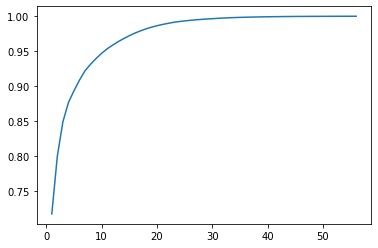

In [105]:
labels=data_steps.iloc[:,data_steps.shape[1]-1]
data=data_steps.iloc[:,0:data_steps.shape[1]-1]
P1=PCA()
res=P1.fit(data)
var=res.explained_variance_ratio_
cum_var=np.cumsum(var)
index=[i for i in range(1,len(var)+1)]
plt.plot(index,cum_var)


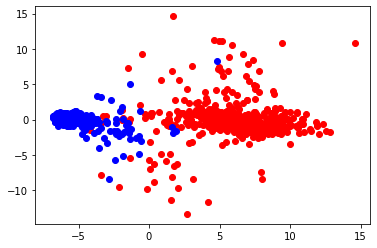

In [106]:
P=PCA(2)
res=P.fit(data)
X=res.transform(data)
X0=[]
X1=[]
Y0=[]
Y1=[]
for i in range(len(labels)):
    if (labels[i]==1):
        X0.append(X[i][0])
        Y0.append(X[i][1])
    else:
        X1.append(X[i][0])
        Y1.append(X[i][1])
X1=np.asarray(X1)
Y1=np.asarray(Y1)
X0=np.asarray(X0)
Y0=np.asarray(Y0)   
### Steps
plt.scatter(X0,Y0,color='red')
### non steps
plt.scatter(X1,Y1,color='blue')
plt.show()

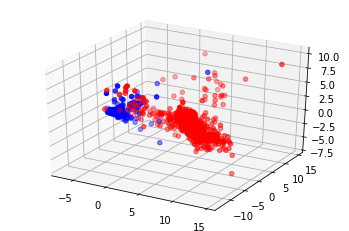

In [107]:
from mpl_toolkits.mplot3d import Axes3D

T=PCA(3)
res=T.fit(data)

X3=res.transform(data)


X0=[]
X1=[]
Y0=[]
Y1=[]
Z0=[]
Z1=[]
for i in range(len(labels)):
    if (labels[i]==1):
        X0.append(X3[i][0])
        Y0.append(X3[i][1])
        Z0.append(X3[i][2])
    else:
        X1.append(X3[i][0])
        Y1.append(X3[i][1])
        Z1.append(X3[i][2])
X1=np.asarray(X1)
Y1=np.asarray(Y1)
X0=np.asarray(X0)
Y0=np.asarray(Y0)
Z0=np.asarray(Z0)
Z1=np.asarray(Z1)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X0,Y0,Z0,color='red')
ax.scatter(X1,Y1,Z1,color='blue')
plt.show()

### Acceleration only

In [108]:
data_steps=[]
for file in files_selected:
    data=get_side_data(data_acquisition(file),'right')
    steps=data[1]
    df=data[0].iloc[:,0:4]
    df=pd.DataFrame(preprocessing.scale(df))
    cp=np.asarray(steps).reshape(len(steps)*2)
    segments=[]
    e=df.shape[0]
    segments.append([0,cp[0]])
    for i in range(len(cp)-1):
        segments.append([cp[i],cp[i+1]])
    segments.append([cp[len(cp)-1],e])
    for s in segments:
        chunk=df.iloc[s[0]:s[1],:]
        vector=np.asarray(chunk.describe().iloc[1:8,]).flatten().tolist()
        if s in steps:
            vector.append(1)
        else:
            vector.append(0)
        data_steps.append(vector)
data_steps=pd.DataFrame(data_steps)

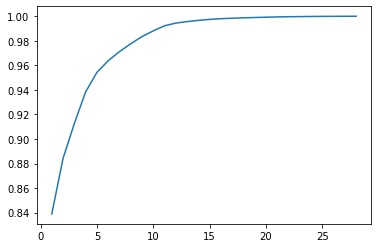

In [109]:
labels=data_steps.iloc[:,data_steps.shape[1]-1]
data=data_steps.iloc[:,0:data_steps.shape[1]-1]
P1=PCA()
res=P1.fit(data)
var=res.explained_variance_ratio_
cum_var=np.cumsum(var)
index=[i for i in range(1,len(var)+1)]
plt.plot(index,cum_var)

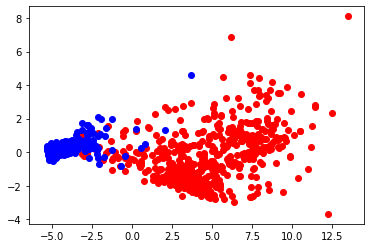

In [110]:
P=PCA(2)
res=P.fit(data)
X=res.transform(data)
X0=[]
X1=[]
Y0=[]
Y1=[]
for i in range(len(labels)):
    if (labels[i]==1):
        X0.append(X[i][0])
        Y0.append(X[i][1])
    else:
        X1.append(X[i][0])
        Y1.append(X[i][1])
X1=np.asarray(X1)
Y1=np.asarray(Y1)
X0=np.asarray(X0)
Y0=np.asarray(Y0)   
### Steps
plt.scatter(X0,Y0,color='red')
### non steps
plt.scatter(X1,Y1,color='blue')
plt.show()

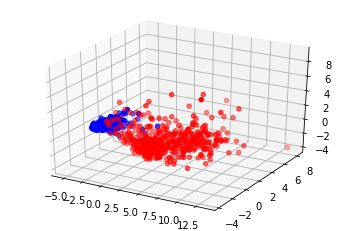

In [111]:
from mpl_toolkits.mplot3d import Axes3D

T=PCA(3)
res=T.fit(data)

X3=res.transform(data)


X0=[]
X1=[]
Y0=[]
Y1=[]
Z0=[]
Z1=[]
for i in range(len(labels)):
    if (labels[i]==1):
        X0.append(X3[i][0])
        Y0.append(X3[i][1])
        Z0.append(X3[i][2])
    else:
        X1.append(X3[i][0])
        Y1.append(X3[i][1])
        Z1.append(X3[i][2])
X1=np.asarray(X1)
Y1=np.asarray(Y1)
X0=np.asarray(X0)
Y0=np.asarray(Y0)
Z0=np.asarray(Z0)
Z1=np.asarray(Z1)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X0,Y0,Z0,color='red')
ax.scatter(X1,Y1,Z1,color='blue')
plt.show()

### Rotation only

In [100]:
data_steps=[]
for file in files_selected:
    data=get_side_data(data_acquisition(file),'right')
    steps=data[1]
    df=data[0].iloc[:,4:8]
    df=pd.DataFrame(preprocessing.scale(df))
    cp=np.asarray(steps).reshape(len(steps)*2)
    segments=[]
    e=df.shape[0]
    segments.append([0,cp[0]])
    for i in range(len(cp)-1):
        segments.append([cp[i],cp[i+1]])
    segments.append([cp[len(cp)-1],e])
    for s in segments:
        chunk=df.iloc[s[0]:s[1],:]
        vector=np.asarray(chunk.describe().iloc[1:8,]).flatten().tolist()
        if s in steps:
            vector.append(1)
        else:
            vector.append(0)
        data_steps.append(vector)
data_steps=pd.DataFrame(data_steps)

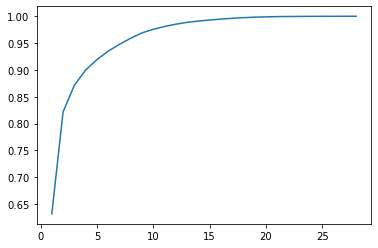

In [101]:
labels=data_steps.iloc[:,data_steps.shape[1]-1]
data=data_steps.iloc[:,0:data_steps.shape[1]-1]
P1=PCA()
res=P1.fit(data)
var=res.explained_variance_ratio_
cum_var=np.cumsum(var)
index=[i for i in range(1,len(var)+1)]
plt.plot(index,cum_var)

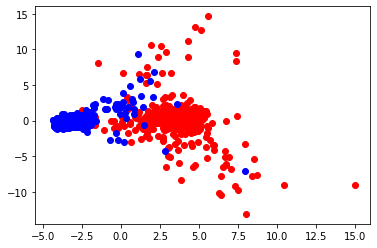

In [102]:
P=PCA(2)
res=P.fit(data)
X=res.transform(data)
X0=[]
X1=[]
Y0=[]
Y1=[]
for i in range(len(labels)):
    if (labels[i]==1):
        X0.append(X[i][0])
        Y0.append(X[i][1])
    else:
        X1.append(X[i][0])
        Y1.append(X[i][1])
X1=np.asarray(X1)
Y1=np.asarray(Y1)
X0=np.asarray(X0)
Y0=np.asarray(Y0)   
### Steps
plt.scatter(X0,Y0,color='red')
### non steps
plt.scatter(X1,Y1,color='blue')
plt.show()

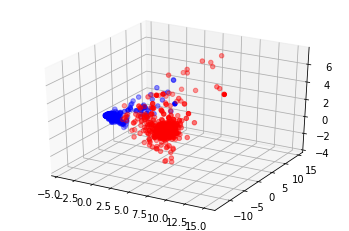

In [103]:
from mpl_toolkits.mplot3d import Axes3D

T=PCA(3)
res=T.fit(data)

X3=res.transform(data)


X0=[]
X1=[]
Y0=[]
Y1=[]
Z0=[]
Z1=[]
for i in range(len(labels)):
    if (labels[i]==1):
        X0.append(X3[i][0])
        Y0.append(X3[i][1])
        Z0.append(X3[i][2])
    else:
        X1.append(X3[i][0])
        Y1.append(X3[i][1])
        Z1.append(X3[i][2])
X1=np.asarray(X1)
Y1=np.asarray(Y1)
X0=np.asarray(X0)
Y0=np.asarray(Y0)
Z0=np.asarray(Z0)
Z1=np.asarray(Z1)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X0,Y0,Z0,color='red')
ax.scatter(X1,Y1,Z1,color='blue')
plt.show()

In [7]:
from main import *
def process(link,method,cost,side):
    print("initiating process for: ",link)
    data=data_acquisition(link)
    meta_data=data[1]
    subject=int(meta_data['Subject'])
    trial=int(meta_data['Trial'])
    data=get_side_data(data,side)
    df=data[0].iloc[:,0:4]
    print(df.shape)
    #df=pd.DataFrame(preprocessing.scale(df))
    steps=data[1]
    data=df
    signals=np.asarray(data)
    bkps=np.asarray(steps)
    bkps=bkps.reshape(bkps.shape[1]*bkps.shape[0])
    algo = method(custom_cost=cost).fit(signals)
    my_bkps = np.asarray(algo.predict(n_bkps=len(bkps)+1))[0:]
    segs=[]
    detected_steps=[]
    L=[]
    data=pd.DataFrame(preprocessing.scale(df))
    for i in range(len(my_bkps)-1):
        segs.append((my_bkps[i],my_bkps[i+1]))
    for s in segs:
        chunk=data.iloc[s[0]:s[1],:]
        scaled=chunk
        summ=scaled.describe().iloc[1:8,]
        vector=np.asarray(summ).flatten()
        #vector=np.linalg.norm(summ,axis=1)
        vector=np.append(vector,[subject,trial])
        L.append(vector)
    L=np.asarray(L)
    print(L.shape)
    return (L,segs)

def chain(directory,method,cost,side,n_indiv,n_try):
  ### Dict that associates each type of pathology to it's files   
# =============================================================================
    df=pd.read_csv("data_label_scaled_acc.csv")



    
#    labels=df.iloc[:,df.shape[1]-1]
#    data=df.iloc[:,0:df.shape[1]-1]
#    data=pd.DataFrame(preprocessing.scale(data))
#    to_del=[i for i in set(np.where(np.isnan(data))[0])]
#    data=data.drop(to_del)

   
    
#    data.insert(data.shape[1],'labels',labels)
#    df=data
    
    

    to_del=[i for i in set(np.where(np.isnan(df))[0])]
    df=df.drop(to_del)
    X=df.iloc[:,0:df.shape[1]-1]
    Y=df.iloc[:,df.shape[1]-1]
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.85)
    print("fitting model ...")
    clf=RandomForestClassifier(n_estimators=100)
    clf.fit(X_train,Y_train)

    pathology_group=dict()
   ### Dict that associates each file it's info     
    info=dict()
 
    L=[]
  ### List of each vector describing a segment + the file code ####  
    for i in range(1,n_indiv+1):
        for j in range(1,n_try+1):

        

            file=directory+"\\"+str(i)+"-"+str(j)+".csv"
            if (str(i)+"-"+str(j)+".csv" in listdir(directory)):
                data=data_acquisition(file)
                meta_data=data[1]
                type_illness=meta_data["PathologyGroup"]
   ##### Assign each file to illness type to keep count ######             
                if (not(type_illness in pathology_group)):
                    pathology_group[type_illness]=[]
                    pathology_group[type_illness].append((i,j))
                else:
                    pathology_group[type_illness].append((i,j))
                    
                
   ##### Construction of a dict to keep track of information in the file ######
                result=process(file,method,cost,side)
                steps=get_side_data(data,side)[1]
                res=result[0]
                segments=result[1]
                info[(i,j)]=(type_illness,segments,steps)
                for k in res:
                    L.append(k)
              
            
        
            else:
                break
    L=np.asarray(L)
    
    X=L[:,0:L.shape[1]-2]
    X=pd.DataFrame(X)
    
    
    Y_pred =clf.predict(X)
    labels=Y_pred
    dict_labels=dict()
#### Storing segments labels for each file ########
    for i in range(len(labels)):
        code=(L[i,L.shape[1]-2],L[i,L.shape[1]-1])
        if (code not in dict_labels):
            dict_labels[code]=[]
            dict_labels[code].append(labels[i])
        else:
            dict_labels[code].append(labels[i])
##### Construction of a dict containing detected_steps + f_score for each file
    results=dict()
    score_pathology=dict()
    for i in dict_labels:
        seg=info[i][1]
        pathology=info[i][0]
        
        steps=info[i][2]
        
        labels=dict_labels[i]
        
        detected_steps=[]
        for j in range(len(labels)):
            if (labels[j]==1):
                detected_steps.append(seg[j])
        #print(detected_steps)
        results[i]=f_score(detected_steps,steps)
        #print(i,"     ",results[i])
        if (pathology in score_pathology):
            score_pathology[pathology]=score_pathology[pathology]+results[i]
        else:
            score_pathology[pathology]=results[i]
    for i in score_pathology:
        score_pathology[i]=score_pathology[i]/len(pathology_group[i])
    
    
    
        
    return(results,score_pathology,L)

link=r"C:\Users\Yassine\Desktop\GaitData\230-5.csv"
side="right"
res=chain(r"C:\Users\Yassine\Desktop\GaitData",rpt.BottomUp,MyCost(),side,230,20)

fitting model ...
(70108, 28)
initiating process for:  C:\Users\Yassine\Desktop\GaitData\1-1.csv
(4013, 4)
(47, 30)
initiating process for:  C:\Users\Yassine\Desktop\GaitData\1-2.csv
(3890, 4)
(49, 30)
initiating process for:  C:\Users\Yassine\Desktop\GaitData\1-3.csv
(3825, 4)
(45, 30)
initiating process for:  C:\Users\Yassine\Desktop\GaitData\1-4.csv
(4093, 4)
(51, 30)
initiating process for:  C:\Users\Yassine\Desktop\GaitData\1-5.csv
(4271, 4)
(47, 30)
initiating process for:  C:\Users\Yassine\Desktop\GaitData\2-1.csv
(2644, 4)
(49, 30)
initiating process for:  C:\Users\Yassine\Desktop\GaitData\2-2.csv
(2856, 4)
(53, 30)
initiating process for:  C:\Users\Yassine\Desktop\GaitData\2-3.csv
(2790, 4)
(51, 30)
initiating process for:  C:\Users\Yassine\Desktop\GaitData\3-1.csv
(2008, 4)
(29, 30)
initiating process for:  C:\Users\Yassine\Desktop\GaitData\3-2.csv
(2075, 4)
(29, 30)
initiating process for:  C:\Users\Yassine\Desktop\GaitData\3-3.csv
(1853, 4)
(27, 30)
initiating process for: 

(27, 30)
initiating process for:  C:\Users\Yassine\Desktop\GaitData\18-4.csv
(2577, 4)
(27, 30)
initiating process for:  C:\Users\Yassine\Desktop\GaitData\19-1.csv
(3168, 4)
(43, 30)
initiating process for:  C:\Users\Yassine\Desktop\GaitData\19-2.csv
(2883, 4)
(43, 30)
initiating process for:  C:\Users\Yassine\Desktop\GaitData\19-3.csv
(2867, 4)
(43, 30)
initiating process for:  C:\Users\Yassine\Desktop\GaitData\20-1.csv
(2043, 4)
(27, 30)
initiating process for:  C:\Users\Yassine\Desktop\GaitData\20-2.csv
(1947, 4)
(27, 30)
initiating process for:  C:\Users\Yassine\Desktop\GaitData\20-3.csv
(2020, 4)
(27, 30)
initiating process for:  C:\Users\Yassine\Desktop\GaitData\20-4.csv
(1925, 4)
(27, 30)
initiating process for:  C:\Users\Yassine\Desktop\GaitData\20-5.csv
(1904, 4)
(27, 30)
initiating process for:  C:\Users\Yassine\Desktop\GaitData\21-1.csv
(2095, 4)
(29, 30)
initiating process for:  C:\Users\Yassine\Desktop\GaitData\21-2.csv
(1449, 4)
(25, 30)
initiating process for:  C:\Users\

(29, 30)
initiating process for:  C:\Users\Yassine\Desktop\GaitData\40-2.csv
(2156, 4)
(31, 30)
initiating process for:  C:\Users\Yassine\Desktop\GaitData\40-3.csv
(2088, 4)
(31, 30)
initiating process for:  C:\Users\Yassine\Desktop\GaitData\40-4.csv
(2065, 4)
(29, 30)
initiating process for:  C:\Users\Yassine\Desktop\GaitData\40-5.csv
(2018, 4)
(31, 30)
initiating process for:  C:\Users\Yassine\Desktop\GaitData\41-1.csv
(2540, 4)
(37, 30)
initiating process for:  C:\Users\Yassine\Desktop\GaitData\41-2.csv
(2381, 4)
(37, 30)
initiating process for:  C:\Users\Yassine\Desktop\GaitData\41-3.csv
(2397, 4)
(33, 30)
initiating process for:  C:\Users\Yassine\Desktop\GaitData\41-4.csv
(2300, 4)
(35, 30)
initiating process for:  C:\Users\Yassine\Desktop\GaitData\41-5.csv
(2258, 4)
(37, 30)
initiating process for:  C:\Users\Yassine\Desktop\GaitData\42-1.csv
(2060, 4)
(31, 30)
initiating process for:  C:\Users\Yassine\Desktop\GaitData\42-2.csv
(1994, 4)
(33, 30)
initiating process for:  C:\Users\

(31, 30)
initiating process for:  C:\Users\Yassine\Desktop\GaitData\63-6.csv
(2268, 4)
(29, 30)
initiating process for:  C:\Users\Yassine\Desktop\GaitData\64-1.csv
(2686, 4)
(31, 30)
initiating process for:  C:\Users\Yassine\Desktop\GaitData\64-2.csv
(2660, 4)
(33, 30)
initiating process for:  C:\Users\Yassine\Desktop\GaitData\64-3.csv
(2803, 4)
(33, 30)
initiating process for:  C:\Users\Yassine\Desktop\GaitData\64-4.csv
(2420, 4)
(31, 30)
initiating process for:  C:\Users\Yassine\Desktop\GaitData\64-5.csv
(2551, 4)
(31, 30)
initiating process for:  C:\Users\Yassine\Desktop\GaitData\64-6.csv
(2413, 4)
(33, 30)
initiating process for:  C:\Users\Yassine\Desktop\GaitData\64-7.csv
(2362, 4)
(33, 30)
initiating process for:  C:\Users\Yassine\Desktop\GaitData\64-8.csv
(2317, 4)
(33, 30)
initiating process for:  C:\Users\Yassine\Desktop\GaitData\65-1.csv
(2118, 4)
(21, 30)
initiating process for:  C:\Users\Yassine\Desktop\GaitData\65-2.csv
(2172, 4)
(21, 30)
initiating process for:  C:\Users\

(29, 30)
initiating process for:  C:\Users\Yassine\Desktop\GaitData\87-1.csv
(3953, 4)
(51, 30)
initiating process for:  C:\Users\Yassine\Desktop\GaitData\87-2.csv
(3696, 4)
(47, 30)
initiating process for:  C:\Users\Yassine\Desktop\GaitData\87-3.csv
(3590, 4)
(47, 30)
initiating process for:  C:\Users\Yassine\Desktop\GaitData\87-4.csv
(3566, 4)
(45, 30)
initiating process for:  C:\Users\Yassine\Desktop\GaitData\87-5.csv
(3470, 4)
(49, 30)
initiating process for:  C:\Users\Yassine\Desktop\GaitData\87-6.csv
(3756, 4)
(51, 30)
initiating process for:  C:\Users\Yassine\Desktop\GaitData\87-7.csv
(3815, 4)
(49, 30)
initiating process for:  C:\Users\Yassine\Desktop\GaitData\87-8.csv
(3546, 4)
(43, 30)
initiating process for:  C:\Users\Yassine\Desktop\GaitData\87-9.csv
(3600, 4)
(47, 30)
initiating process for:  C:\Users\Yassine\Desktop\GaitData\87-10.csv
(3606, 4)
(47, 30)
initiating process for:  C:\Users\Yassine\Desktop\GaitData\88-1.csv
(2600, 4)
(39, 30)
initiating process for:  C:\Users

(59, 30)
initiating process for:  C:\Users\Yassine\Desktop\GaitData\105-1.csv
(1829, 4)
(29, 30)
initiating process for:  C:\Users\Yassine\Desktop\GaitData\105-2.csv
(1797, 4)
(27, 30)
initiating process for:  C:\Users\Yassine\Desktop\GaitData\105-3.csv
(1602, 4)
(27, 30)
initiating process for:  C:\Users\Yassine\Desktop\GaitData\105-4.csv
(1741, 4)
(27, 30)
initiating process for:  C:\Users\Yassine\Desktop\GaitData\105-5.csv
(1474, 4)
(27, 30)
initiating process for:  C:\Users\Yassine\Desktop\GaitData\106-1.csv
(2571, 4)
(27, 30)
initiating process for:  C:\Users\Yassine\Desktop\GaitData\106-2.csv
(2138, 4)
(29, 30)
initiating process for:  C:\Users\Yassine\Desktop\GaitData\106-3.csv
(2079, 4)
(29, 30)
initiating process for:  C:\Users\Yassine\Desktop\GaitData\106-4.csv
(2116, 4)
(29, 30)
initiating process for:  C:\Users\Yassine\Desktop\GaitData\106-5.csv
(2053, 4)
(29, 30)
initiating process for:  C:\Users\Yassine\Desktop\GaitData\107-1.csv
(10372, 4)
(113, 30)
initiating process fo

(49, 30)
initiating process for:  C:\Users\Yassine\Desktop\GaitData\129-2.csv
(3041, 4)
(51, 30)
initiating process for:  C:\Users\Yassine\Desktop\GaitData\129-3.csv
(2954, 4)
(47, 30)
initiating process for:  C:\Users\Yassine\Desktop\GaitData\129-4.csv
(2943, 4)
(47, 30)
initiating process for:  C:\Users\Yassine\Desktop\GaitData\129-5.csv
(2822, 4)
(47, 30)
initiating process for:  C:\Users\Yassine\Desktop\GaitData\130-1.csv
(2388, 4)
(27, 30)
initiating process for:  C:\Users\Yassine\Desktop\GaitData\130-2.csv
(2426, 4)
(27, 30)
initiating process for:  C:\Users\Yassine\Desktop\GaitData\131-1.csv
(2076, 4)
(27, 30)
initiating process for:  C:\Users\Yassine\Desktop\GaitData\131-2.csv
(2128, 4)
(27, 30)
initiating process for:  C:\Users\Yassine\Desktop\GaitData\131-3.csv
(2118, 4)
(27, 30)
initiating process for:  C:\Users\Yassine\Desktop\GaitData\131-4.csv
(1983, 4)
(27, 30)
initiating process for:  C:\Users\Yassine\Desktop\GaitData\131-5.csv
(1874, 4)
(27, 30)
initiating process for:

(35, 30)
initiating process for:  C:\Users\Yassine\Desktop\GaitData\150-3.csv
(2473, 4)
(35, 30)
initiating process for:  C:\Users\Yassine\Desktop\GaitData\150-4.csv
(2465, 4)
(35, 30)
initiating process for:  C:\Users\Yassine\Desktop\GaitData\150-5.csv
(2510, 4)
(35, 30)
initiating process for:  C:\Users\Yassine\Desktop\GaitData\151-1.csv
(3264, 4)
(41, 30)
initiating process for:  C:\Users\Yassine\Desktop\GaitData\151-2.csv
(3141, 4)
(43, 30)
initiating process for:  C:\Users\Yassine\Desktop\GaitData\151-3.csv
(3225, 4)
(43, 30)
initiating process for:  C:\Users\Yassine\Desktop\GaitData\151-4.csv
(3219, 4)
(41, 30)
initiating process for:  C:\Users\Yassine\Desktop\GaitData\151-5.csv
(2988, 4)
(39, 30)
initiating process for:  C:\Users\Yassine\Desktop\GaitData\151-6.csv
(3125, 4)
(41, 30)
initiating process for:  C:\Users\Yassine\Desktop\GaitData\151-7.csv
(2948, 4)
(41, 30)
initiating process for:  C:\Users\Yassine\Desktop\GaitData\151-8.csv
(3079, 4)
(39, 30)
initiating process for:

(49, 30)
initiating process for:  C:\Users\Yassine\Desktop\GaitData\170-1.csv
(3084, 4)
(45, 30)
initiating process for:  C:\Users\Yassine\Desktop\GaitData\170-2.csv
(2682, 4)
(43, 30)
initiating process for:  C:\Users\Yassine\Desktop\GaitData\171-1.csv
(2774, 4)
(31, 30)
initiating process for:  C:\Users\Yassine\Desktop\GaitData\171-2.csv
(2908, 4)
(31, 30)
initiating process for:  C:\Users\Yassine\Desktop\GaitData\172-1.csv
(1994, 4)
(25, 30)
initiating process for:  C:\Users\Yassine\Desktop\GaitData\172-2.csv
(1991, 4)
(25, 30)
initiating process for:  C:\Users\Yassine\Desktop\GaitData\172-3.csv
(1917, 4)
(25, 30)
initiating process for:  C:\Users\Yassine\Desktop\GaitData\172-4.csv
(2007, 4)
(29, 30)
initiating process for:  C:\Users\Yassine\Desktop\GaitData\172-5.csv
(2099, 4)
(27, 30)
initiating process for:  C:\Users\Yassine\Desktop\GaitData\173-1.csv
(2421, 4)
(29, 30)
initiating process for:  C:\Users\Yassine\Desktop\GaitData\173-2.csv
(2458, 4)
(27, 30)
initiating process for:

(51, 30)
initiating process for:  C:\Users\Yassine\Desktop\GaitData\193-1.csv
(2253, 4)
(33, 30)
initiating process for:  C:\Users\Yassine\Desktop\GaitData\193-2.csv
(2187, 4)
(31, 30)
initiating process for:  C:\Users\Yassine\Desktop\GaitData\193-3.csv
(2240, 4)
(33, 30)
initiating process for:  C:\Users\Yassine\Desktop\GaitData\193-4.csv
(2082, 4)
(29, 30)
initiating process for:  C:\Users\Yassine\Desktop\GaitData\193-5.csv
(2291, 4)
(29, 30)
initiating process for:  C:\Users\Yassine\Desktop\GaitData\194-1.csv
(2296, 4)
(33, 30)
initiating process for:  C:\Users\Yassine\Desktop\GaitData\194-2.csv
(2102, 4)
(31, 30)
initiating process for:  C:\Users\Yassine\Desktop\GaitData\194-3.csv
(2208, 4)
(33, 30)
initiating process for:  C:\Users\Yassine\Desktop\GaitData\194-4.csv
(2139, 4)
(33, 30)
initiating process for:  C:\Users\Yassine\Desktop\GaitData\194-5.csv
(2071, 4)
(31, 30)
initiating process for:  C:\Users\Yassine\Desktop\GaitData\195-1.csv
(4198, 4)
(55, 30)
initiating process for:

(31, 30)
initiating process for:  C:\Users\Yassine\Desktop\GaitData\215-6.csv
(2053, 4)
(31, 30)
initiating process for:  C:\Users\Yassine\Desktop\GaitData\216-1.csv
(2551, 4)
(35, 30)
initiating process for:  C:\Users\Yassine\Desktop\GaitData\216-2.csv
(2442, 4)
(35, 30)
initiating process for:  C:\Users\Yassine\Desktop\GaitData\217-1.csv
(3008, 4)
(37, 30)
initiating process for:  C:\Users\Yassine\Desktop\GaitData\217-2.csv
(3055, 4)
(37, 30)
initiating process for:  C:\Users\Yassine\Desktop\GaitData\218-1.csv
(2204, 4)
(25, 30)
initiating process for:  C:\Users\Yassine\Desktop\GaitData\218-2.csv
(2353, 4)
(25, 30)
initiating process for:  C:\Users\Yassine\Desktop\GaitData\218-3.csv
(2254, 4)
(27, 30)
initiating process for:  C:\Users\Yassine\Desktop\GaitData\218-4.csv
(2315, 4)
(25, 30)
initiating process for:  C:\Users\Yassine\Desktop\GaitData\218-5.csv
(2302, 4)
(25, 30)
initiating process for:  C:\Users\Yassine\Desktop\GaitData\218-6.csv
(2266, 4)
(25, 30)
initiating process for:

In [8]:
print(res[1])
print(np.asarray([*res[0].values()]).mean())

{'Neurological': 0.9530883294983327, 'Healthy': 0.9685246176028468, 'Orthopedic': 0.9603317069813595}
0.9584068570728002


In [2]:
from main import *
def process(link,method,cost,side):
    print("initiating process for: ",link)
    data=data_acquisition(link)
    meta_data=data[1]
    subject=int(meta_data['Subject'])
    trial=int(meta_data['Trial'])
    data=get_side_data(data,side)
    df=data[0].iloc[:,4:8]
    #df=pd.DataFrame(preprocessing.scale(df))
    steps=data[1]
    data=df
    signals=np.asarray(data)
    bkps=np.asarray(steps)
    bkps=bkps.reshape(bkps.shape[1]*bkps.shape[0])
    algo = method(custom_cost=cost).fit(signals)
    my_bkps = np.asarray(algo.predict(n_bkps=len(bkps)+1))[0:]
    segs=[]
    detected_steps=[]
    L=[]
    data=pd.DataFrame(preprocessing.scale(df))
    for i in range(len(my_bkps)-1):
        segs.append((my_bkps[i],my_bkps[i+1]))
    for s in segs:
        chunk=data.iloc[s[0]:s[1],:]
        scaled=chunk
        summ=scaled.describe().iloc[1:8,]
        vector=np.asarray(summ).flatten()
        #vector=np.linalg.norm(summ,axis=1)
        vector=np.append(vector,[subject,trial])
        L.append(vector)
    L=np.asarray(L)
    return (L,segs)

def chain(directory,method,cost,side,n_indiv,n_try):
  ### Dict that associates each type of pathology to it's files   
# =============================================================================
    df=pd.read_csv("data_label_scaled_rot.csv")



    
#    labels=df.iloc[:,df.shape[1]-1]
#    data=df.iloc[:,0:df.shape[1]-1]
#    data=pd.DataFrame(preprocessing.scale(data))
#    to_del=[i for i in set(np.where(np.isnan(data))[0])]
#    data=data.drop(to_del)

   
    
#    data.insert(data.shape[1],'labels',labels)
#    df=data
    
    

    to_del=[i for i in set(np.where(np.isnan(df))[0])]
    df=df.drop(to_del)
    X=df.iloc[:,0:df.shape[1]-1]
    Y=df.iloc[:,df.shape[1]-1]
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.85)
    print("fitting model ...")
    clf=RandomForestClassifier(n_estimators=100)
    clf.fit(X_train,Y_train)

    pathology_group=dict()
   ### Dict that associates each file it's info     
    info=dict()
 
    L=[]
  ### List of each vector describing a segment + the file code ####  
    for i in range(1,n_indiv+1):
        for j in range(1,n_try+1):

        

            file=directory+"\\"+str(i)+"-"+str(j)+".csv"
            if (str(i)+"-"+str(j)+".csv" in listdir(directory)):
                data=data_acquisition(file)
                meta_data=data[1]
                type_illness=meta_data["PathologyGroup"]
   ##### Assign each file to illness type to keep count ######             
                if (not(type_illness in pathology_group)):
                    pathology_group[type_illness]=[]
                    pathology_group[type_illness].append((i,j))
                else:
                    pathology_group[type_illness].append((i,j))
                    
                
   ##### Construction of a dict to keep track of information in the file ######
                result=process(file,method,cost,side)
                steps=get_side_data(data,side)[1]
                res=result[0]
                segments=result[1]
                info[(i,j)]=(type_illness,segments,steps)
                for k in res:
                    L.append(k)
              
            
        
            else:
                break
    L=np.asarray(L)
    
    X=L[:,0:L.shape[1]-2]
    X=pd.DataFrame(X)
    
    
    Y_pred =clf.predict(X)
    labels=Y_pred
    dict_labels=dict()
#### Storing segments labels for each file ########
    for i in range(len(labels)):
        code=(L[i,L.shape[1]-2],L[i,L.shape[1]-1])
        if (code not in dict_labels):
            dict_labels[code]=[]
            dict_labels[code].append(labels[i])
        else:
            dict_labels[code].append(labels[i])
##### Construction of a dict containing detected_steps + f_score for each file
    results=dict()
    score_pathology=dict()
    for i in dict_labels:
        seg=info[i][1]
        pathology=info[i][0]
        
        steps=info[i][2]
        
        labels=dict_labels[i]
        
        detected_steps=[]
        for j in range(len(labels)):
            if (labels[j]==1):
                detected_steps.append(seg[j])
        #print(detected_steps)
        results[i]=f_score(detected_steps,steps)
        #print(i,"     ",results[i])
        if (pathology in score_pathology):
            score_pathology[pathology]=score_pathology[pathology]+results[i]
        else:
            score_pathology[pathology]=results[i]
    for i in score_pathology:
        score_pathology[i]=score_pathology[i]/len(pathology_group[i])
    
    
    
        
    return(results,score_pathology,L)

link=r"C:\Users\Yassine\Desktop\GaitData\230-5.csv"
side="right"
res=chain(r"C:\Users\Yassine\Desktop\GaitData",rpt.BottomUp,MyCost(),side,230,20)

fitting model ...
initiating process for:  C:\Users\Yassine\Desktop\GaitData\1-1.csv
initiating process for:  C:\Users\Yassine\Desktop\GaitData\1-2.csv
initiating process for:  C:\Users\Yassine\Desktop\GaitData\1-3.csv
initiating process for:  C:\Users\Yassine\Desktop\GaitData\1-4.csv
initiating process for:  C:\Users\Yassine\Desktop\GaitData\1-5.csv
initiating process for:  C:\Users\Yassine\Desktop\GaitData\2-1.csv
initiating process for:  C:\Users\Yassine\Desktop\GaitData\2-2.csv
initiating process for:  C:\Users\Yassine\Desktop\GaitData\2-3.csv
initiating process for:  C:\Users\Yassine\Desktop\GaitData\3-1.csv
initiating process for:  C:\Users\Yassine\Desktop\GaitData\3-2.csv
initiating process for:  C:\Users\Yassine\Desktop\GaitData\3-3.csv
initiating process for:  C:\Users\Yassine\Desktop\GaitData\3-4.csv
initiating process for:  C:\Users\Yassine\Desktop\GaitData\3-5.csv
initiating process for:  C:\Users\Yassine\Desktop\GaitData\4-1.csv
initiating process for:  C:\Users\Yassine\De

initiating process for:  C:\Users\Yassine\Desktop\GaitData\24-4.csv
initiating process for:  C:\Users\Yassine\Desktop\GaitData\25-1.csv
initiating process for:  C:\Users\Yassine\Desktop\GaitData\25-2.csv
initiating process for:  C:\Users\Yassine\Desktop\GaitData\25-3.csv
initiating process for:  C:\Users\Yassine\Desktop\GaitData\25-4.csv
initiating process for:  C:\Users\Yassine\Desktop\GaitData\25-5.csv
initiating process for:  C:\Users\Yassine\Desktop\GaitData\25-6.csv
initiating process for:  C:\Users\Yassine\Desktop\GaitData\26-1.csv
initiating process for:  C:\Users\Yassine\Desktop\GaitData\26-2.csv
initiating process for:  C:\Users\Yassine\Desktop\GaitData\27-1.csv
initiating process for:  C:\Users\Yassine\Desktop\GaitData\27-2.csv
initiating process for:  C:\Users\Yassine\Desktop\GaitData\27-3.csv
initiating process for:  C:\Users\Yassine\Desktop\GaitData\27-4.csv
initiating process for:  C:\Users\Yassine\Desktop\GaitData\27-5.csv
initiating process for:  C:\Users\Yassine\Deskto

initiating process for:  C:\Users\Yassine\Desktop\GaitData\53-2.csv
initiating process for:  C:\Users\Yassine\Desktop\GaitData\53-3.csv
initiating process for:  C:\Users\Yassine\Desktop\GaitData\53-4.csv
initiating process for:  C:\Users\Yassine\Desktop\GaitData\53-5.csv
initiating process for:  C:\Users\Yassine\Desktop\GaitData\54-1.csv
initiating process for:  C:\Users\Yassine\Desktop\GaitData\54-2.csv
initiating process for:  C:\Users\Yassine\Desktop\GaitData\54-3.csv
initiating process for:  C:\Users\Yassine\Desktop\GaitData\54-4.csv
initiating process for:  C:\Users\Yassine\Desktop\GaitData\54-5.csv
initiating process for:  C:\Users\Yassine\Desktop\GaitData\55-1.csv
initiating process for:  C:\Users\Yassine\Desktop\GaitData\55-2.csv
initiating process for:  C:\Users\Yassine\Desktop\GaitData\55-3.csv
initiating process for:  C:\Users\Yassine\Desktop\GaitData\55-4.csv
initiating process for:  C:\Users\Yassine\Desktop\GaitData\55-5.csv
initiating process for:  C:\Users\Yassine\Deskto

initiating process for:  C:\Users\Yassine\Desktop\GaitData\81-5.csv
initiating process for:  C:\Users\Yassine\Desktop\GaitData\82-1.csv
initiating process for:  C:\Users\Yassine\Desktop\GaitData\82-2.csv
initiating process for:  C:\Users\Yassine\Desktop\GaitData\82-3.csv
initiating process for:  C:\Users\Yassine\Desktop\GaitData\82-4.csv
initiating process for:  C:\Users\Yassine\Desktop\GaitData\83-1.csv
initiating process for:  C:\Users\Yassine\Desktop\GaitData\83-2.csv
initiating process for:  C:\Users\Yassine\Desktop\GaitData\83-3.csv
initiating process for:  C:\Users\Yassine\Desktop\GaitData\84-1.csv
initiating process for:  C:\Users\Yassine\Desktop\GaitData\84-2.csv
initiating process for:  C:\Users\Yassine\Desktop\GaitData\85-1.csv
initiating process for:  C:\Users\Yassine\Desktop\GaitData\85-2.csv
initiating process for:  C:\Users\Yassine\Desktop\GaitData\85-3.csv
initiating process for:  C:\Users\Yassine\Desktop\GaitData\85-4.csv
initiating process for:  C:\Users\Yassine\Deskto

initiating process for:  C:\Users\Yassine\Desktop\GaitData\107-1.csv
initiating process for:  C:\Users\Yassine\Desktop\GaitData\107-2.csv
initiating process for:  C:\Users\Yassine\Desktop\GaitData\108-1.csv
initiating process for:  C:\Users\Yassine\Desktop\GaitData\108-2.csv
initiating process for:  C:\Users\Yassine\Desktop\GaitData\108-3.csv
initiating process for:  C:\Users\Yassine\Desktop\GaitData\109-1.csv
initiating process for:  C:\Users\Yassine\Desktop\GaitData\109-2.csv
initiating process for:  C:\Users\Yassine\Desktop\GaitData\109-3.csv
initiating process for:  C:\Users\Yassine\Desktop\GaitData\109-4.csv
initiating process for:  C:\Users\Yassine\Desktop\GaitData\110-1.csv
initiating process for:  C:\Users\Yassine\Desktop\GaitData\110-2.csv
initiating process for:  C:\Users\Yassine\Desktop\GaitData\110-3.csv
initiating process for:  C:\Users\Yassine\Desktop\GaitData\111-1.csv
initiating process for:  C:\Users\Yassine\Desktop\GaitData\111-2.csv
initiating process for:  C:\Users\

initiating process for:  C:\Users\Yassine\Desktop\GaitData\135-1.csv
initiating process for:  C:\Users\Yassine\Desktop\GaitData\135-2.csv
initiating process for:  C:\Users\Yassine\Desktop\GaitData\136-1.csv
initiating process for:  C:\Users\Yassine\Desktop\GaitData\137-1.csv
initiating process for:  C:\Users\Yassine\Desktop\GaitData\137-2.csv
initiating process for:  C:\Users\Yassine\Desktop\GaitData\137-3.csv
initiating process for:  C:\Users\Yassine\Desktop\GaitData\138-1.csv
initiating process for:  C:\Users\Yassine\Desktop\GaitData\138-2.csv
initiating process for:  C:\Users\Yassine\Desktop\GaitData\138-3.csv
initiating process for:  C:\Users\Yassine\Desktop\GaitData\138-4.csv
initiating process for:  C:\Users\Yassine\Desktop\GaitData\138-5.csv
initiating process for:  C:\Users\Yassine\Desktop\GaitData\139-1.csv
initiating process for:  C:\Users\Yassine\Desktop\GaitData\139-2.csv
initiating process for:  C:\Users\Yassine\Desktop\GaitData\139-3.csv
initiating process for:  C:\Users\

initiating process for:  C:\Users\Yassine\Desktop\GaitData\161-3.csv
initiating process for:  C:\Users\Yassine\Desktop\GaitData\161-4.csv
initiating process for:  C:\Users\Yassine\Desktop\GaitData\162-1.csv
initiating process for:  C:\Users\Yassine\Desktop\GaitData\162-2.csv
initiating process for:  C:\Users\Yassine\Desktop\GaitData\162-3.csv
initiating process for:  C:\Users\Yassine\Desktop\GaitData\162-4.csv
initiating process for:  C:\Users\Yassine\Desktop\GaitData\162-5.csv
initiating process for:  C:\Users\Yassine\Desktop\GaitData\162-6.csv
initiating process for:  C:\Users\Yassine\Desktop\GaitData\162-7.csv
initiating process for:  C:\Users\Yassine\Desktop\GaitData\162-8.csv
initiating process for:  C:\Users\Yassine\Desktop\GaitData\162-9.csv
initiating process for:  C:\Users\Yassine\Desktop\GaitData\163-1.csv
initiating process for:  C:\Users\Yassine\Desktop\GaitData\163-2.csv
initiating process for:  C:\Users\Yassine\Desktop\GaitData\163-3.csv
initiating process for:  C:\Users\

initiating process for:  C:\Users\Yassine\Desktop\GaitData\191-4.csv
initiating process for:  C:\Users\Yassine\Desktop\GaitData\191-5.csv
initiating process for:  C:\Users\Yassine\Desktop\GaitData\191-6.csv
initiating process for:  C:\Users\Yassine\Desktop\GaitData\191-7.csv
initiating process for:  C:\Users\Yassine\Desktop\GaitData\192-1.csv
initiating process for:  C:\Users\Yassine\Desktop\GaitData\192-2.csv
initiating process for:  C:\Users\Yassine\Desktop\GaitData\192-3.csv
initiating process for:  C:\Users\Yassine\Desktop\GaitData\192-4.csv
initiating process for:  C:\Users\Yassine\Desktop\GaitData\192-5.csv
initiating process for:  C:\Users\Yassine\Desktop\GaitData\193-1.csv
initiating process for:  C:\Users\Yassine\Desktop\GaitData\193-2.csv
initiating process for:  C:\Users\Yassine\Desktop\GaitData\193-3.csv
initiating process for:  C:\Users\Yassine\Desktop\GaitData\193-4.csv
initiating process for:  C:\Users\Yassine\Desktop\GaitData\193-5.csv
initiating process for:  C:\Users\

initiating process for:  C:\Users\Yassine\Desktop\GaitData\219-5.csv
initiating process for:  C:\Users\Yassine\Desktop\GaitData\220-1.csv
initiating process for:  C:\Users\Yassine\Desktop\GaitData\220-2.csv
initiating process for:  C:\Users\Yassine\Desktop\GaitData\220-3.csv
initiating process for:  C:\Users\Yassine\Desktop\GaitData\220-4.csv
initiating process for:  C:\Users\Yassine\Desktop\GaitData\220-5.csv
initiating process for:  C:\Users\Yassine\Desktop\GaitData\221-1.csv
initiating process for:  C:\Users\Yassine\Desktop\GaitData\221-2.csv
initiating process for:  C:\Users\Yassine\Desktop\GaitData\221-3.csv
initiating process for:  C:\Users\Yassine\Desktop\GaitData\221-4.csv
initiating process for:  C:\Users\Yassine\Desktop\GaitData\221-5.csv
initiating process for:  C:\Users\Yassine\Desktop\GaitData\222-1.csv
initiating process for:  C:\Users\Yassine\Desktop\GaitData\222-2.csv
initiating process for:  C:\Users\Yassine\Desktop\GaitData\222-3.csv
initiating process for:  C:\Users\

In [3]:
print(res[1])
print(np.asarray([*res[0].values()]).mean())

{'Neurological': 0.9418837183007375, 'Healthy': 0.9355148960751654, 'Orthopedic': 0.9390135941070487}
0.9397177623263285
